In [ ]:
using Pkg
Pkg.activate(".")
using OrdinaryDiffEq, Plots, NCDatasets, LinearAlgebra, Statistics
using Flux, Optimisers, Parameters, MLDataPattern, CairoMakie

  Activating project at `~/Documents/Studium/7_Mastersemester/Modellierung_mit_Julia`


In [2]:
# open NetCDF
ds = Dataset("run_0003/output.nc")

# explore variable names
println(keys(ds))  # check what's inside, e.g. "u", "lat", "lon", "lev", "time"

# load arrays
u = ds["u"]          # dimensions likely (lon, lat, lev, time)
lat = ds["lat"]
lon = ds["lon"]
time = ds["time"]
ds

["time", "lon", "lat", "layer", "soil_layer", "v", "u", "vor"]


Dataset: run_0003/output.nc
Group: /

Dimensions
   time = 1601
   lon = 96
   lat = 48
   layer = 8
   soil_layer = 2

Variables
  time   (1601)
    Datatype:    Dates.DateTime (Float64)
    Dimensions:  time
    Attributes:
     units                = hours since 2000-01-01 00:00:0.0
     calendar             = proleptic_gregorian
     long_name            = time
     standard_name        = time

  lon   (96)
    Datatype:    Float64 (Float64)
    Dimensions:  lon
    Attributes:
     units                = degrees_east
     long_name            = longitude

  lat   (48)
    Datatype:    Float64 (Float64)
    Dimensions:  lat
    Attributes:
     units                = degrees_north
     long_name            = latitude

  layer   (8)
    Datatype:    Float32 (Float32)
    Dimensions:  layer
    Attributes:
     units                = 1
     long_name            = sigma layer

  soil_layer   (2)
    Datatype:    Int64 (Int64)
    Dimensions:  soil_layer
    Attributes:
     units     

In [5]:
# find indices where latitude >= 0
lat_idx = findall(>=(0), lat)

# extract zonal wind only for NH
u_NH = u[:, lat_idx, :, :]   # shape: (lon, nlat, lev, time)
lat_NH = lat[lat_idx]

u_jet = u[:, :, 2, 1:1600] 

96×48×1600 Array{Union{Missing, Float32}, 3}:
[:, :, 1] =
 8.625    12.3125  16.5     21.75   …   -6.78125   -3.79688     1.84375
 8.4375   12.0     16.125   21.625      -6.5625    -2.92188     3.03125
 8.1875   11.6875  15.8125  21.5        -6.3125    -2.04688     4.21875
 7.96875  11.3125  15.5     21.25       -6.09375   -1.16406     5.4375
 7.71875  11.0     15.3125  21.375      -5.84375   -0.285156    6.625
 7.5      10.8125  15.25    21.375  …   -5.625      0.515625    7.78125
 7.21875  10.625   15.1875  21.5        -5.40625    1.32031     8.8125
 6.9375   10.375   15.125   21.75       -5.15625    2.125       9.8125
 6.65625  10.1875  15.25    22.0        -4.875      2.92188    10.8125
 6.375    10.0625  15.4375  22.25       -4.59375    3.625      11.8125
 6.09375  10.0     15.5625  22.75   …   -4.28125    4.3125     12.6875
 5.78125   9.875   15.8125  23.25       -4.03125    5.03125    13.375
 5.46875   9.75    16.125   23.75       -3.78125    5.71875    14.0625
 ⋮               

In [6]:
nlon, nlat, nt = size(u_jet)
X = reshape(u_jet, nlon*nlat, nt)  # (space, time)

# transpose: now rows = time, cols = space
X = permutedims(X)   # (time, space)
X_timemean = mean(X, dims=1)

# subtract temporal mean at each grid point
X_anom = X .- X_timemean

1600×4608 Matrix{Float32}:
 -0.806772   -0.54229    -0.342754   …  -1.24675   -1.38453   -1.51911
 -0.744272   -0.54229    -0.342754      -1.28582   -1.4275    -1.56599
 -0.744272   -0.54229    -0.342754      -1.22332   -1.365     -1.49958
 -0.931772   -0.72979    -0.561504      -1.19207   -1.31031   -1.42536
 -0.994272   -0.79229    -0.592754      -1.45769   -1.52125   -1.59528
 -0.806772   -0.60479    -0.405254   …  -1.77019   -1.76734   -1.76716
 -0.494272   -0.29229    -0.155254      -1.84832   -1.78296   -1.71052
 -0.369272   -0.22979    -0.0927544     -1.86394   -1.75171   -1.63434
 -0.369272   -0.22979    -0.155254      -1.78582   -1.65796   -1.51911
 -0.244272   -0.16729    -0.0302544     -1.75457   -1.615     -1.47224
 -0.0567722   0.0827103   0.157246   …  -1.44207   -1.31031   -1.17536
 -0.0567722   0.0827103   0.157246      -0.988942  -0.872808  -0.757392
 -0.431772   -0.29229    -0.217754      -0.29363   -0.204839  -0.116767
  ⋮                                  ⋱   ⋮      

In [7]:
# covariance matrix in space
C = X_anom' * X_anom / (size(X_anom, 1) - 1)
C


4608×4608 Matrix{Float32}:
 5.38482   5.31591   5.24797   5.17862   …  0.496985  0.36003   0.223876
 5.31591   5.2659    5.21598   5.16514      0.49705   0.364823  0.233475
 5.24797   5.21598   5.18475   5.15214      0.494364  0.366957  0.240512
 5.17862   5.16514   5.15214   5.13871      0.493113  0.370566  0.249064
 5.11105   5.11586   5.1211    5.12592      0.492421  0.374839  0.258376
 5.02087   5.04381   5.0671    5.09027   …  0.487073  0.374278  0.262689
 4.84694   4.88696   4.92726   4.96769      0.463179  0.355319  0.248718
 4.67056   4.72758   4.78483   4.84249      0.438392  0.335498  0.233916
 4.49549   4.56949   4.64364   4.71846      0.411762  0.313639  0.216883
 4.31988   4.41092   4.50206   4.59412      0.388738  0.295611  0.203905
 4.11278   4.21941   4.32605   4.43387   …  0.353817  0.265302  0.178245
 3.85838   3.97838   4.09832   4.21969      0.306341  0.222006  0.139151
 3.60346   3.73682   3.87006   4.00494      0.259073  0.179078  0.100571
 ⋮                      

In [8]:
eig_vals, eig_vecs = eigen(C, sortby=-)

# principal components (time series)
PCs = X_anom * eig_vecs

frac_var = eig_vals ./ sum(eig_vals)
println("Fraction explained by first 6 EOFs: ", frac_var[1:6])

EOF1 = reshape(eig_vecs[:,1], nlon, nlat)  # reshape back to lon-lat
EOF2 = reshape(eig_vecs[:,2], nlon, nlat)  # reshape back to lon-lat
EOF3 = reshape(eig_vecs[:,3], nlon, nlat)  # reshape back to lon-lat

Fraction explained by first 6 EOFs: Float32[0.56705916, 0.093764186, 0.033865955, 0.022881938, 0.021908509, 0.01993514]


96×48 Matrix{Float32}:
 0.00925788  0.0116131   0.0134113   …  -0.00193438   -0.00244277
 0.00933526  0.0119142   0.0140925      -0.0027259    -0.00357403
 0.00940212  0.012184    0.0148166      -0.00351316   -0.0047006
 0.00947291  0.0124706   0.015525       -0.00430504   -0.00582657
 0.00955264  0.0127687   0.0161103      -0.00509119   -0.00695513
 0.00958604  0.012853    0.0166051   …  -0.00606385   -0.00807583
 0.00947771  0.0129276   0.0171         -0.00704755   -0.00916959
 0.00935944  0.0130054   0.0175263      -0.00803241   -0.0102603
 0.00924657  0.0130963   0.0176351      -0.00899004   -0.0113617
 0.0091348   0.0128884   0.0177342      -0.0101028    -0.0124573
 0.00893685  0.0126794   0.0178379   …  -0.0112262    -0.0134642
 0.0086215   0.0124732   0.0176168      -0.0123239    -0.014382
 0.00830114  0.0122625   0.0172286      -0.0134363    -0.0152961
 ⋮                                   ⋱                
 0.00557064  0.00719654  0.00726283      0.00334057    0.00817429
 0.005

In [148]:
K = 6   # number of PCs to retain
A = PCs[:, 1:K]'           # now shape is (K × time)
EOFs = eig_vecs[:, 1:K]

X_train = A[:, 1:end-1]
Y_train = A[:, 2:end]

M = Y_train * pinv(X_train)   # (K × K)

a_pred = similar(A)
a_pred[:, 1] .= A[:, 1]

for t in 2:size(A,2)
    a_pred[:, t] .= M * a_pred[:, t-1]
end

In [149]:
using Flux, DiffEqFlux, OrdinaryDiffEq, NODEData, Dates
X_nn = transpose(X_train) # (T-1) × K 
Y_nn = transpose(Y_train) # (T-1) × K
t = Float32.(Dates.value.(Hour.(time .- time[1])))
dt = t[2] - t[1]
x0 = A[:, 1]  # initial PC state

"""
    prepare_data(t::AbstractVector, X::AbstractMatrix; train_frac=0.8, batchsize=10)

Splits data into train and validation sets and returns batches:

# Returns
- `train_batches::Vector{Tuple{Vector{Float32}, Matrix{Float32}}}`
- `valid_batches::Vector{Tuple{Vector{Float32}, Matrix{Float32}}}`
"""
function prepare_data(t::AbstractVector, X::AbstractMatrix; train_frac=0.8, batchsize=10)
    # Convert to Float32

    N = size(X, 1)  # number of time points
    split_idx = Int(floor(N * train_frac))

    t_train, t_valid = t[1:split_idx], t[split_idx+1:end]
    X_train, X_valid = X[1:split_idx, :], X[split_idx+1:end, :]

    function make_batches(t::AbstractVector, X::AbstractMatrix, batchsize::Int)
        N = size(X, 1)  # number of columns = time points
        batches = []

        for start in 1:batchsize:N
            stop = min(start + batchsize - 1, N)
            t_batch = t[start:stop]
            X_batch = X[start:stop,:]
            push!(batches, (t_batch, X_batch))
        end

        return batches
    end

    train_batches = make_batches(t_train, X_train, batchsize)
    valid_batches = make_batches(t_valid, X_valid, batchsize)

    return train_batches, valid_batches, split_idx
end

train, valid, split_idx = prepare_data(t, X_nn, batchsize=10)
typeof(train[1])

Tuple{Vector{Float32}, Matrix{Float32}}

In [150]:
train[1][2]

10×6 Matrix{Float32}:
 668.673  -416.104  -11.2971   -24.1976  128.382    4.14606
 666.447  -412.732  -11.0997   -27.6735  116.732   11.0049
 666.569  -407.157   -9.50118  -32.3975  105.56    17.482
 669.642  -400.068   -7.97326  -38.9147   95.2086  23.0736
 673.408  -391.219   -7.22881  -45.7407   88.6117  30.654
 677.215  -382.659   -5.34258  -52.2694   84.6318  36.5746
 679.049  -376.167   -2.27941  -56.3293   83.2841  38.2351
 680.998  -372.389    2.63908  -59.6417   83.1505  35.0902
 681.542  -371.238    9.03768  -62.4678   84.175   28.8662
 682.359  -370.985   14.3984   -65.1056   87.0164  23.1349

In [152]:


# Define neural network approximating d(a)/dt
nn = Flux.Chain(
    Flux.Dense(K, 64, swish),
    Flux.Dense(64, 128, swish),
    Flux.Dense(128, 64, swish),
    Flux.Dense(64, K)
)

p, re_nn = Flux.destructure(nn)

neural_ode(u, p, t) = re_nn(p)(u)

nn_prob = ODEProblem(neural_ode, x0, (Float32(0.), Float32(dt)), p)
nn_prob

ODEProblem with uType Vector{Float32} and tType Float32. In-place: false
Non-trivial mass matrix: false
timespan: (0.0f0, 6.0f0)
u0: 6-element Vector{Float32}:
  668.6731
 -416.10352
  -11.2971325
  -24.197588
  128.38171
    4.146061

In [153]:
abstract type AbstractChaoticNDEModel end 

"""
    ChaoticNDE{P,R,A,K} <: AbstractChaoticNDEModel

Model for setting up and training Chaotic Neural Differential Equations.

# Fields:

* `p` parameter vector 
* `prob` DEProblem 
* `alg` Algorithm to use for the `solve` command 
* `kwargs` any additional keyword arguments that should be handed over (e.g. `sensealg`)

# Constructor 

`ChaoticNDE(prob; alg=Tsit5(), kwargs...)`
"""
struct ChaoticNDE{P,R,A} <: AbstractChaoticNDEModel
    p::P 
    prob::R 
    alg::A
end 

function ChaoticNDE(prob; alg=Tsit5())
    p = prob.p 
    ChaoticNDE{typeof(p), typeof(prob), typeof(alg)}(p, prob, alg)
end 

Flux.@layer ChaoticNDE
Optimisers.trainable(m::ChaoticNDE) = (p=m.p,)

function (m::ChaoticNDE)(X, p=m.p)
    (t, x) = X 
    Array(solve(remake(m.prob; tspan=(t[1],t[end]), u0=x[1,:],p=p), m.alg; saveat=t))
end

model = ChaoticNDE(nn_prob)
loss(m, x, y) = Flux.mse(m(x), y') 
model(train[1])

6×10 Matrix{Float32}:
  668.673     550.106   492.76    332.361  …   1473.92     3454.06    8309.57
 -416.104    -391.602  -326.46   -134.41        560.665    1123.95    2486.22
  -11.2971    140.653   389.536   575.769      2626.84     5809.38   13485.3
  -24.1976    276.962   611.244   918.28       7592.92    15851.5    34037.0
  128.382     314.242   503.561   536.971     -5020.99   -12057.8   -26930.9
    4.14606  -251.336  -526.439  -701.963  …  -7701.44   -17090.0   -37245.6

In [135]:
η = 1f-3
opt = Optimisers.Adam(η)
opt_state = Optimisers.setup(opt, model)

(p = Leaf(Adam(eta=0.001, beta=(0.9, 0.999), epsilon=1.0e-8), (Float32[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0  …  0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], Float32[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0  …  0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], (0.9, 0.999))), prob = (), alg = ())

In [138]:
println("starting training...")

for epoch = 1:100 
    Flux.train!(model, train, opt_state) do m, t, x 
        loss(m, (t,x), x)
    end

    if (epoch % 20) == 0  # reduce the learning rate every 30 epochs
        η /= 2
        Optimisers.adjust!(opt_state, η)
    end
end 

println("... and finished.")

starting training...
... and finished.


In [143]:
Δt_start = 10          # stride between forecast starts (in time steps)
lead_time = 10        # how many steps you want to forecast
start_indices = split_idx:Δt_start:(size(A,2) - lead_time)

nstarts = length(start_indices)
a_pred_all = Array{Float64}(undef, K, lead_time, nstarts)
a_pred_nn = Array{Float64}(undef, K, lead_time, nstarts)

for (j, t0) in enumerate(start_indices)
    a_pred_all[:, 1, j] .= A[:, t0]  # initialize with true PC at t0
    for τ in 2:lead_time
        a_pred_all[:, τ, j] .= M * a_pred_all[:, τ-1, j]
    end
    a_pred_nn[:, :, j] .= model(valid[j])
end

a_true_all = Array{Float64}(undef, K, lead_time, nstarts)
for (j, t0) in enumerate(start_indices)
    a_true_all[:, :, j] .= A[:, t0:(t0+lead_time-1)]
end

nspace = size(X,2)
lead_time = size(a_pred_all, 2)
nstarts = size(a_pred_all, 3)

X_recon_all = Array{Float64}(undef, nspace, lead_time, nstarts)
X_recon_nn = Array{Float64}(undef, nspace, lead_time, nstarts)

for j in 1:nstarts
    for τ in 1:lead_time
        X_recon_all[:, τ, j] .= X_timemean[:] .+ EOFs[:, 1:K] * a_pred_all[:, τ, j]
        X_recon_nn[:, τ, j] .= X_timemean[:] .+ EOFs[:, 1:K] * a_pred_nn[:, τ, j]
    end
end

X_true_all = Array{Float64}(undef, nspace, lead_time, nstarts)

for (j, t0) in enumerate(start_indices)
    X_true_all[:, :, j] .= X[t0:(t0+lead_time-1), :]'
end

In [144]:
# Compute RMSE at each lead time for each simulation
rmse_all = zeros(lead_time, nspace)
rmse_nn = zeros(lead_time, nspace)
rmse_persistence = zeros(lead_time, nspace)

for j in 1:nstarts
    for τ in 1:lead_time
        rmse_all[τ, j] = sqrt(mean((X_true_all[:, τ, j] - X_recon_all[:, τ, j]).^2))
        rmse_nn[τ, j] = sqrt(mean((X_true_all[:, τ, j] - X_recon_nn[:, τ, j]).^2))
        rmse_persistence[τ, j] = sqrt(mean((X_true_all[:, τ, j] - X_true_all[:, 1, j]).^2))
    end
end


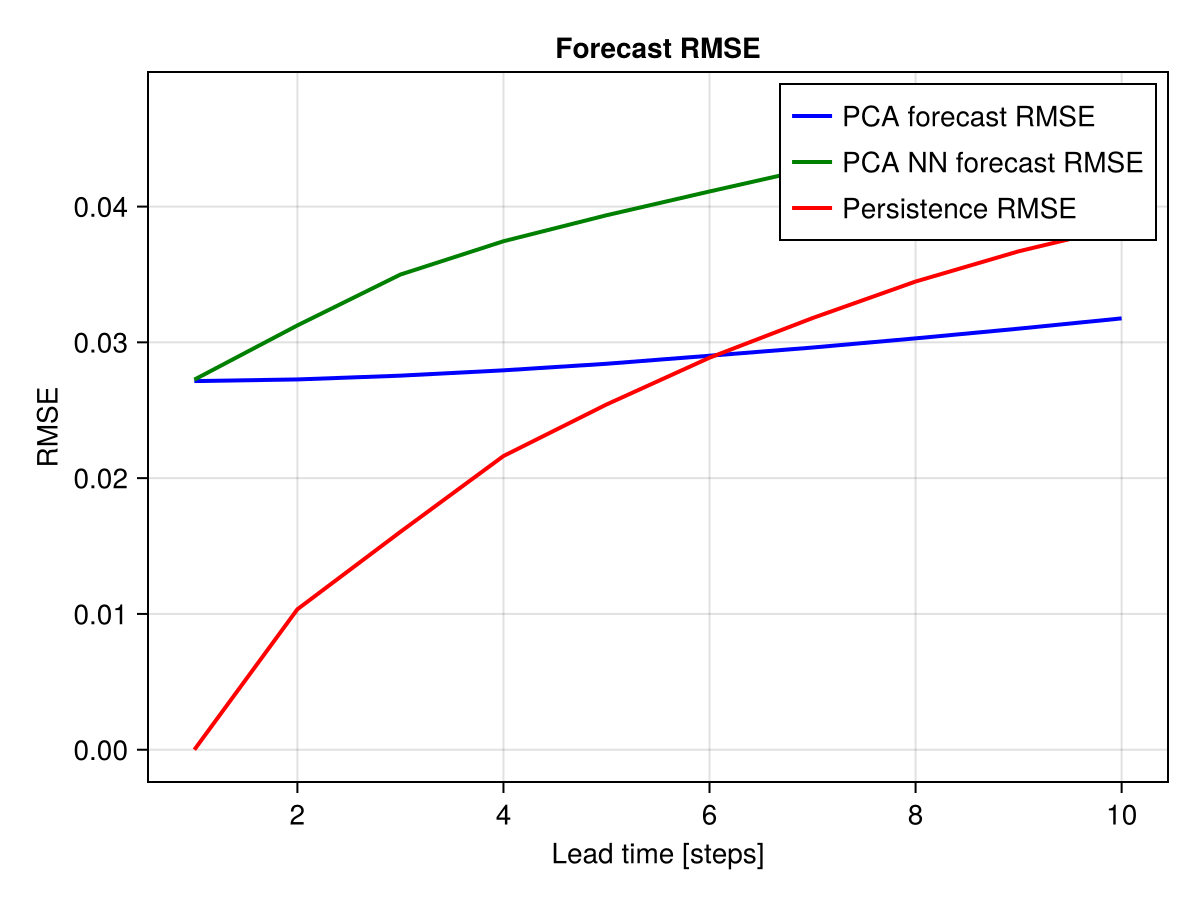

In [156]:
rmse_mean = mean(rmse_all, dims=2)
rmse_mean_nn = mean(rmse_nn, dims=2)
rmse_pers_mean = mean(rmse_persistence, dims=2)

# Plot
fig = Figure()
ax = Axis(fig[1,1], xlabel="Lead time [steps]", ylabel="RMSE", title="Forecast RMSE")
lines!(ax, 1:lead_time, rmse_mean[:], color=:blue, linewidth=2, label="PCA forecast RMSE")
lines!(ax, 1:lead_time, rmse_mean_nn[:], color=:green, linewidth=2, label="PCA NN forecast RMSE")
lines!(ax, 1:lead_time, rmse_pers_mean[:], color=:red, linewidth=2, label="Persistence RMSE")
axislegend(ax)
fig